In [1]:
#!/usr/bin/python
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.debugger import set_trace

# Import

In [19]:
# IMPORT PACKAGES
import os, sys
import numpy as np
import logging
from tqdm import tqdm
from tqdm.autonotebook import tqdm as tqdm_notebook
# FileIO
import json
from pathlib import Path
# Image processing
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from PIL import ImagePath as PILImagePath
import skimage.io as skio
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
# COCO tools
from pycocotools import mask
from pycocotools.coco import COCO
# utils
from datetime import datetime
import time
from easydict import EasyDict as edict
import numpy as np
import random
# Custom packages
user_dir = os.path.expanduser('~')
project_dir = Path(user_dir) / 'serviceBot'
sys.path.append(project_dir)
from utils import get_varargin, timeit
import logger_utils
logger_utils.logging_setup()

In [444]:
%autoreload 2
import coco_utils

In [ ]:
coco_utils.coco_json_utils()

In [3]:
annoDir = project_dir / 'Downloads/coco2017/annotations'
anno_file = annoDir /'instances_val2017.json'
coco = COCO(anno_file)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [3]:
def create_coco_info(**kwargs):
    description = get_varargin(kwargs, 'description', 'Custom COCO dataset')
    url = get_varargin(kwargs, 'url', '')
    version = get_varargin(kwargs, 'version', '1.0')
    year = get_varargin(kwargs, 'year', datetime.today().year)
    contributor = get_varargin(kwargs, 'contributor', 'Trieu Phat Luu')
    date_created = get_varargin(kwargs, 'date_created', datetime.today().strftime('%Y/%m/%d'))
    
    coco_info = edict()
    coco_info.description = description
    coco_info.url = url
    coco_info.version = version
    coco_info.year = year
    coco_info.contributor = contributor
    coco_info.date_created = date_created
    return coco_info

# coco_json_utils

In [25]:
class coco_json_utils(object):
    def __init__(self, json_filepath):
        self.json_filepath = json_filepath
        self.load_json()
# =================================================================================================================
# METHODS
    def load_json(self, **kwargs):
        """
        Load .json file and create json object
        """
        if not os.path.isfile(self.json_filepath):
            logging.error('{} is not exist'.format(self.json_filepath))
            raise FileNotFoundError('{} is not exist'.format(self.json_filepath))
        else:
            self.coco = COCO(self.json_filepath)
            with open(self.json_filepath) as fid:
                logging.info('Open file: {}'.format(self.json_filepath))
                self.json_obj = json.load(fid)
                
    def get_keys(self, **kwargs):
        key_list = list(self.json_obj.keys())
        self.json_key = key_list
        return key_list
    
    def display_coco_info(self, **kwargs):
        key = get_varargin(kwargs, 'key', 'info')
        item_id = get_varargin(kwargs, 'id', None)
        if key == 'info':
            self.coco.info()
        elif key == 'category':
            cat_id = item_id
            cat_list = self.coco.loadCats(self.coco.getCatIds())
            if cat_id is None:
                print('Number of categories: {}'.format(len(cat_list)))
                nms = [cat['name'] for cat in cat_list]
                print('COCO categories: \n{}\n'.format(' '.join(nms)))
                print('Category list in Json file')
                print(cat_list)
            else:
                cat_id_list = [cat['id'] for cat in cat_list]
                if cat_id in cat_id_list:
                    idx = cat_id_list.index(cat_id)
                    print(cat_list[idx])
                else:
                    print('Category ID: {} is not found'.format(cat_id))
        elif key == 'image':
            img_id = item_id
            img_list = self.coco.loadImgs(self.coco.getImgIds())
            if img_id is None:
                print('Number of Images: {}'.format(len(img_list)))
                print(img_list)
            else:
                img_id_list = [img['id'] for img in img_list]
                if img_id in img_id_list:
                    idx = img_id_list.index(img_id)
                    print(img_list[idx])
                else:
                    print('Image ID: {} is not found'.format(img_id))
        else:
            pass
    
    def get_cat_name(self, catIds):
        coco_cat = self.coco.loadCats(self.coco.getCatIds())
        cat_id_list = [cat['id'] for cat in coco_cat]
        if catIds in cat_id_list:
            idx = cat_id_list.index(catIds)
            return coco_cat[idx]['name']
        else:
            print('Category ID: {} is not found'.format(catIds))
        
    def get_coco_img(self, **kwargs):
        cat_names = get_varargin(kwargs, 'cat_names', None)
        nb_img = get_varargin(kwargs, 'nb_image', 1)
        coco_cats = self.coco.getCatIds(catNms = cat_names)
        img_id = self.coco.getImgIds(catIds = coco_cats)
        if nb_img > len(img_id):
            nb_img = len(img_id)
        pick = np.random.choice(len(img_id), size = nb_img, replace=False)
        sel_img_id = [img_id[i] for i in pick]
        coco_img = self.coco.loadImgs(sel_img_id)
        return coco_img
    
    def get_coco_img_id(self, **kwargs):
        cat_names = get_varargin(kwargs, 'cat_names', None)
        nb_img = get_varargin(kwargs, 'nb_image', 1)
        coco_img_list = self.get_coco_img(cat_names = cat_names, nb_image = nb_img)
        img_id = [coco_img['id'] for coco_img in coco_img_list]
        return img_id
        
    
    def plt_image(self,coco_img_list, **kwargs):
        img_dir = get_varargin(kwargs, 'image_dir', None)
        show_mask = get_varargin(kwargs, 'show_mask', True)
        display_cat = get_varargin(kwargs, 'display_cat', True)
        for img_info in coco_img_list:
            if img_dir is None:
                img = skio.imread(img_info['coco_url'])
            else:
                img = skio.imread(Path(img_dir) / img_info['file_name'])
            plt.imshow(img)
            plt.axis('off')
            if show_mask is True:
                annIds = self.coco.getAnnIds(imgIds = img_info['id'])
                anns = self.coco.loadAnns(annIds)
                self.coco.showAnns(anns)
            plt.show()
            if display_cat is True:
                annIds = self.coco.getAnnIds(imgIds = img_info['id'])
                anns = self.coco.loadAnns(annIds)
                
    def export_segmentation_png(self, coco_img_list, **kwargs):
        export_dir = get_varargin(kwargs, 'export_dir', os.getcwd())
        display_opt = get_varargin(kwargs, 'display', True)
        if not os.path.exists(export_dir):
            os.makedirs(export_dir)
#         imgId_list = [coco_img['id'] for coco_img in coco_img_list]
        filename_list = [os.path.splitext(coco_img['file_name'])[0] for coco_img in coco_img_list]
        for coco_img, filename in tqdm(zip(coco_img_list, filename_list)):
            imgId = coco_img['id']
            pngPath = Path(export_dir) / '{}.png'.format(filename)
            self.cocoSegmentationToPng(self.coco, imgId, pngPath)
            if display_opt is True:    
                plt.figure()
                plt.imshow(skio.imread(pngPath))
                plt.axis('off')
                
    
    def get_key_values(self, **kwargs):
        """
        Get key value from json object
        Options:
            keys: List of key to get value. Default: All key
        """
        key_list = self.get_keys()
        input_keys = get_varargin(kwargs, 'keys', key_list)
        display_opt = get_varargin(kwargs, 'display', True)
        for key in input_keys:
            if key in key_list:
                strcmd = "self.{} = self.json_obj.get('{}')".format(key,key)
                exec(strcmd)                
                if display_opt is True:
                    strcmd = "print(self.{})".format(key)
                    exec(strcmd)
            else:
                logging.info('Key not exist in coco json file: {}'.format(key))
                
# STATIC FUNCTIONS
    @staticmethod
    def cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=False, includeCrowd=False):
        '''
        Convert COCO GT or results for a single image to a segmentation map.
        :param coco: an instance of the COCO API (ground-truth or result)
        :param imgId: the id of the COCO image
        :param checkUniquePixelLabel: (optional) whether every pixel can have at most one label
        :param includeCrowd: whether to include 'crowd' thing annotations as 'other' (or void)
        :return: labelMap - [h x w] segmentation map that indicates the label of each pixel
        '''

        # Init
        curImg = coco.imgs[imgId]
        imageSize = (curImg['height'], curImg['width'])
        labelMap = np.zeros(imageSize)

        # Get annotations of the current image (may be empty)
        imgAnnots = [a for a in coco.anns.values() if a['image_id'] == imgId]
        if includeCrowd:
            annIds = coco.getAnnIds(imgIds=imgId)
        else:
            annIds = coco.getAnnIds(imgIds=imgId, iscrowd=False)
        imgAnnots = coco.loadAnns(annIds)

        # Combine all annotations of this image in labelMap
        #labelMasks = mask.decode([a['segmentation'] for a in imgAnnots])
        for a in range(0, len(imgAnnots)):
            labelMask = coco.annToMask(imgAnnots[a]) == 1
            #labelMask = labelMasks[:, :, a] == 1
            newLabel = imgAnnots[a]['category_id']

            if checkUniquePixelLabel and (labelMap[labelMask] != 0).any():
                raise Exception('Error: Some pixels have more than one label (image %d)!' % (imgId))

            labelMap[labelMask] = newLabel

        return labelMap
    
    @staticmethod
    def cocoSegmentationToPng(coco, imgId, pngPath, includeCrowd=False):
        '''
        Convert COCO GT or results for a single image to a segmentation map and write it to disk.
        :param coco: an instance of the COCO API (ground-truth or result)
        :param imgId: the COCO id of the image (last part of the file name)
        :param pngPath: the path of the .png file
        :param includeCrowd: whether to include 'crowd' thing annotations as 'other' (or void)
        :return: None
        '''

        # Create label map
        labelMap = coco_json_utils.cocoSegmentationToSegmentationMap(coco, imgId, includeCrowd=includeCrowd)
        labelMap = labelMap.astype(np.int8)

        # Get color map and convert to PIL's format
        cmap = coco_json_utils.getCMap()
        cmap = (cmap * 255).astype(int)
        padding = np.zeros((256-cmap.shape[0], 3), np.int8)
        cmap = np.vstack((cmap, padding))
        cmap = cmap.reshape((-1))
        assert len(cmap) == 768, 'Error: Color map must have exactly 256*3 elements!'

        # Write to png file
        png = PILImage.fromarray(labelMap).convert('P')
    #     png.putpalette(cmap) # Luu 191031: Error: Invalid Palette size
        png.save(pngPath, format='PNG')
        
    @staticmethod
    def getCMap(stuffStartId=92, stuffEndId=182, cmapName='jet', addThings=True, addUnlabeled=True, addOther=True):
        '''
        Create a color map for the classes in the COCO Stuff Segmentation Challenge.
        :param stuffStartId: (optional) index where stuff classes start
        :param stuffEndId: (optional) index where stuff classes end
        :param cmapName: (optional) Matlab's name of the color map
        :param addThings: (optional) whether to add a color for the 91 thing classes
        :param addUnlabeled: (optional) whether to add a color for the 'unlabeled' class
        :param addOther: (optional) whether to add a color for the 'other' class
        :return: cmap - [c, 3] a color map for c colors where the columns indicate the RGB values
        '''

        # Get jet color map from Matlab
        labelCount = stuffEndId - stuffStartId + 1
        cmapGen = matplotlib.cm.get_cmap(cmapName, labelCount)
        cmap = cmapGen(np.arange(labelCount))
        cmap = cmap[:, 0:3]

        # Reduce value/brightness of stuff colors (easier in HSV format)
        cmap = cmap.reshape((-1, 1, 3))
        hsv = matplotlib.colors.rgb_to_hsv(cmap)
        hsv[:, 0, 2] = hsv[:, 0, 2] * 0.7
        cmap = matplotlib.colors.hsv_to_rgb(hsv)
        cmap = cmap.reshape((-1, 3))

        # Permute entries to avoid classes with similar name having similar colors
        st0 = np.random.get_state()
        np.random.seed(42)
        perm = np.random.permutation(labelCount)
        np.random.set_state(st0)
        cmap = cmap[perm, :]

        # Add black (or any other) color for each thing class
        if addThings:
            thingsPadding = np.zeros((stuffStartId - 1, 3))
            cmap = np.vstack((thingsPadding, cmap))

        # Add black color for 'unlabeled' class
        if addUnlabeled:
            cmap = np.vstack(((0.0, 0.0, 0.0), cmap))

        # Add yellow/orange color for 'other' class
        if addOther:
            cmap = np.vstack((cmap, (1.0, 0.843, 0.0)))

        return cmap


In [206]:
coco_json = coco_json_utils(anno_file)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
20191102-06:39 | <ipython-input-205-59de2cd61574> - INFO - Open file: /home/phatluu/serviceBot/Downloads/cocostuffapi/annotations/instances_val2017.json


In [158]:
import requests
def download_file_url(pic_url, filepath):
    export_dir = os.path.dirname(filepath)
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
    with open(filepath, 'wb') as handle:
        response = requests.get(pic_url, stream=True)
        if not response.ok:
            print(response)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)

In [341]:
annoDir = project_dir / 'datasets/coco_example'
anno_file = annoDir /'coco_seg_to_png.json'
coco_json = coco_json_utils(anno_file)
coco_img = coco_json.get_coco_img(cat_names = ['person', 'dog'], nb_image = 10)
export_dir = Path(project_dir) / 'datasets/coco_example/segmentation_validate'
coco_json.export_segmentation_png(coco_img, export_dir = export_dir)
# export_dir = Path(project_dir) / 'datasets/coco_example/originalImage'
# for img in coco_img:
#     download_file_url(img['coco_url'], export_dir / img['file_name'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
20191103-01:45 | <ipython-input-340-bbe850558f8f> - INFO - Open file: /home/phatluu/serviceBot/datasets/coco_example/coco_seg_to_png.json


KeyError: 288685.0

In [341]:
annoDir = project_dir / 'datasets/coco_example'
anno_file = annoDir /'coco_seg_to_png.json'
coco_json = coco_json_utils(anno_file)
coco_img = coco_json.get_coco_img(cat_names = ['person', 'dog'], nb_image = 10)
export_dir = Path(project_dir) / 'datasets/coco_example/segmentation_validate'
coco_json.export_segmentation_png(coco_img, export_dir = export_dir)
# export_dir = Path(project_dir) / 'datasets/coco_example/originalImage'
# for img in coco_img:
#     download_file_url(img['coco_url'], export_dir / img['file_name'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
20191103-01:45 | <ipython-input-340-bbe850558f8f> - INFO - Open file: /home/phatluu/serviceBot/datasets/coco_example/coco_seg_to_png.json


KeyError: 288685.0

In [341]:
annoDir = project_dir / 'datasets/coco_example'
anno_file = annoDir /'coco_seg_to_png.json'
coco_json = coco_json_utils(anno_file)
coco_img = coco_json.get_coco_img(cat_names = ['person', 'dog'], nb_image = 10)
export_dir = Path(project_dir) / 'datasets/coco_example/segmentation_validate'
coco_json.export_segmentation_png(coco_img, export_dir = export_dir)
# export_dir = Path(project_dir) / 'datasets/coco_example/originalImage'
# for img in coco_img:
#     download_file_url(img['coco_url'], export_dir / img['file_name'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
20191103-01:45 | <ipython-input-340-bbe850558f8f> - INFO - Open file: /home/phatluu/serviceBot/datasets/coco_example/coco_seg_to_png.json


KeyError: 288685.0

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
20191102-02:19 | <ipython-input-78-4fca794381a8> - INFO - Open file: /home/phatluu/serviceBot/Downloads/cocostuffapi/annotations/instances_val2017.json


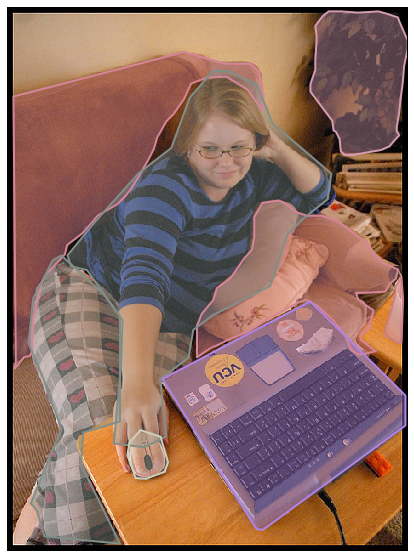

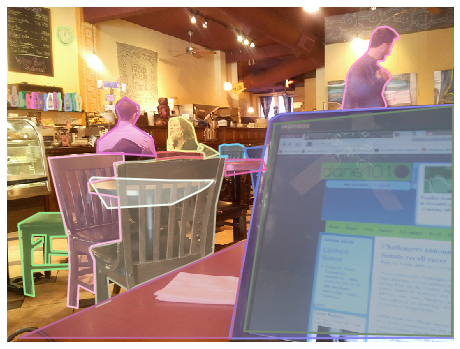

In [89]:
coco_img = coco_json.get_coco_img(cat_names = ['person', 'laptop'], nb_image = 2)
coco_json.plt_image(coco_img)

In [5]:
class coco_licenses(object):
   # Initialize Class
    def __init__(self):
        self._licenses = []
# =================================================================================================================
    @property
    def licenses(self):
        return self._licenses
    @licenses.setter
    def licenses(self, licenses_list):
        self._licenses = licenses_list
# =================================================================================================================
# METHODS
    def add_license(self, **kwargs):
        lic_url = get_varargin(kwargs, 'url', '')
        lic_id = get_varargin(kwargs, 'id', 1)
        lic_name = get_varargin(kwargs, 'name', 'No known Copyright restriction')
        lic_dict = edict()
        lic_dict.url = lic_url
        lic_dict.id = lic_id
        lic_dict.name = lic_name
        self.licenses.append(lic_dict)
        
    def get_license(self, license_id, **kwargs):
        display_opt = get_varargin(kwargs, 'display', True)
        lic = edict()
        for lic in self.licenses:
            if license_id == lic['id']:
                return lic
            
    def remove_license(self, license_id, **kwargs):
        for idx, lic in enumerate(self.licenses):
            if license_id == lic['id']:
                self.licenses.pop(idx)
# =================================================================================================================
# STATIC METHODS
    @staticmethod
    def function1(**kwargs):
        pass

In [6]:
class coco_categories(object):
   # Initialize Class
    def __init__(self):
        self._categories = []
# =================================================================================================================
    @property
    def categories(self):
        return self._categories
    @categories.setter
    def categories(self, cat_list):
        self._categories = cat_list
# =================================================================================================================
# METHODS
    def add_category(self, **kwargs):
        supercat = get_varargin(kwargs, 'supercategory', '')
        cat_id = get_varargin(kwargs, 'id', None)
        cat_name = get_varargin(kwargs, 'name', '') 
        category = edict()
        category.supercategory = supercat
        category.id = cat_id
        category.name = cat_name
        self.categories.append(category)
    def get_category(self, cat_id, **kwargs):
        cat = edict()
        for cat in self.categories:
            if cat_id == cat['id']:
                return cat
    def remove_category(self, cat_id, **kwargs):
        for idx, cat in enumerate(self.categories):
            if cat_id == cat['id']:
                self.categories.pop(idx)
# =================================================================================================================
# STATIC METHODS
    @staticmethod
    def function1(**kwargs):
        pass

# coco_images

In [7]:
class coco_images(object):
   # Initialize Class
    def __init__(self):
        self._images = []
# =================================================================================================================
    @property
    def images(self):
        return self._images
    @images.setter
    def images(self, coco_img_list):
        self._images = coco_img_list
# =================================================================================================================
# METHODS
    def add_image(self, **kwargs):
        image = edict()
        image.id = get_varargin(kwargs, 'id', None)
        image.license = get_varargin(kwargs, 'license', None)
        image.file_name = get_varargin(kwargs, 'file_name', '')
        image.img_url = get_varargin(kwargs, 'img_url', '')
        image.height = get_varargin(kwargs, 'height', None)
        image.width = get_varargin(kwargs, 'width', None)
        self.images.append(image)
        
    def get_image(self, img_id, **kwargs):
        img = edict()
        for img in self.images:
            if img_id == img['id']:
                return img
            
    def remove_image(self, img_id, **kwargs):
        for idx, img in enumerate(self.images):
            if img_id == img['id']:
                self.images.pop(idx)
    
    def add_image_from_file(self, filepath, **kwargs):
        license = get_varargin(kwargs, 'license', 0)
        coco_url = get_varargin(kwargs, 'coco_url', '')
        date_captured = get_varargin(kwargs, 'date_captured', datetime.now().strftime('%Y-%m-%d %H:%M:%S') )
        
        filepath = Path(filepath)
        filename = filepath.name
        img = skio.imread(filepath)
#         Get list of category except for background
        height, width = img.shape[:2]
        img_id = int(os.path.splitext(filename)[0])
        coco_img = edict()
        coco_img.license = license
        coco_img.file_name = filename
        coco_img.coco_url = ''
        coco_img.height = height
        coco_img.width = width
        coco_img.date_captured = date_captured
        coco_img.id = img_id
        self.images.append(coco_img)
# =================================================================================================================
# STATIC METHODS
    @staticmethod
    def function1(**kwargs):
        pass

In [409]:
anno_dir = Path(project_dir) / 'datasets/coco_example/segmentation'
filelist = os.listdir(anno_dir)
sel_file = anno_dir / filelist[0]
print(sel_file)
img_obj = coco_images()
img_obj.add_coco_image_from_file(sel_file)

/home/phatluu/serviceBot/datasets/coco_example/segmentation/000000288685.png
436 640


# coco_annotations

In [11]:
from skimage import measure
class coco_annotations(object):
   # Initialize Class
    def __init__(self):
        self._annotations = []
# =================================================================================================================
    @property
    def annotations(self):
        return self._annotations
    @annotations.setter
    def annotations(self, annotations_list):
        self._annotations = annotations_list
# =================================================================================================================
# METHODS
    def add_annotations(self, **kwargs):
        annotation = edict()
        annotation.segmentation = get_varargin(kwargs, 'segmentation', '')
        annotation.area = get_varargin(kwargs, 'area', None)
        annotation.iscrowd = get_varargin(kwargs, 'iscrowd', None)
        annotation.image_id = get_varargin(kwargs, 'image_id', None)
        annotation.bbox = get_varargin(kwargs, 'bbox', None)
        annotation.category_id = get_varargin(kwargs, 'category_id', None)
        annotation.id = get_varargin(kwargs, 'id', None)
        self.annotations.append(annotation)
        
    def get_annotation(self, ann_id, **kwargs):
        ann = edict()
        for ann in self.annotations:
            if ann_id == ann['id']:
                return ann
            
    def remove_annotation(self, ann_id, **kwargs):
        for idx, ann in enumerate(self.annotations):
            if ann_id == ann['id']:
                self.annotations.pop(idx)
    
    def add_annotation_from_png(self, filepath, **kwargs):
        filepath = Path(filepath)
        filename = filepath.name
        mask_img = skio.imread(filepath)
#         Get list of category except for background
        catId_list = np.unique(mask_img)[1:]
        filename = os.path.splitext(filename)[0]
        
        img_id = int(filename)
        
        for catId in catId_list:
            catmask = np.where(mask_img == catId, catId, 0)
            category_info = edict()
            category_info.id = int(catId)
            category_info.is_crowd = 0
            annotation_id = img_id + int(catId)
            
            cat_anno = self.create_annotation_info(annotation_id, img_id, category_info, catmask, 
                                   image_size=None, tolerance=2, bounding_box=None)
            self.annotations.append(cat_anno)
            
        
# =================================================================================================================
# STATIC METHODS
    @staticmethod
    def resize_binary_mask(array, new_size):
        image = Image.fromarray(array.astype(np.uint8)*255)
        image = image.resize(new_size)
        return np.asarray(image).astype(np.bool_)
    
    @staticmethod
    def close_contour(contour):
        if not np.array_equal(contour[0], contour[-1]):
            contour = np.vstack((contour, contour[0]))
        return contour
    
    @staticmethod
    def binary_mask_to_rle(binary_mask):
        rle = {'counts': [], 'size': list(binary_mask.shape)}
        counts = rle.get('counts')
        for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
            if i == 0 and value == 1:
                    counts.append(0)
            counts.append(len(list(elements)))

        return rle

    @staticmethod
    def binary_mask_to_polygon(binary_mask, tolerance=0):
        """Converts a binary mask to COCO polygon representation
        Args:
            binary_mask: a 2D binary numpy array where '1's represent the object
            tolerance: Maximum distance from original points of polygon to approximated
                polygonal chain. If tolerance is 0, the original coordinate array is returned.
        """
        polygons = []
        # pad mask to close contours of shapes which start and end at an edge
        padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
        contours = measure.find_contours(padded_binary_mask, 0.5)
        contours = np.subtract(contours, 1)
        for contour in contours:
            contour = coco_annotations.close_contour(contour)
            contour = measure.approximate_polygon(contour, tolerance)
            if len(contour) < 3:
                continue
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            # after padding and subtracting 1 we may get -0.5 points in our segmentation 
            segmentation = [0 if i < 0 else round(i*100)/100 for i in segmentation]
            polygons.append(segmentation)

        return polygons

    @staticmethod
    def create_image_info(image_id, file_name, image_size, 
                          date_captured = datetime.utcnow().isoformat(' '),
                          license_id=1, coco_url="", flickr_url=""):

        image_info = {
                "id": image_id,
                "file_name": file_name,
                "width": image_size[0],
                "height": image_size[1],
                "date_captured": date_captured,
                "license": license_id,
                "coco_url": coco_url,
                "flickr_url": flickr_url
        }

        return image_info

    @staticmethod
    def create_annotation_info(annotation_id, image_id, category_info, binary_mask, 
                               image_size=None, tolerance=2, bounding_box=None):

        if image_size is not None:
            binary_mask = resize_binary_mask(binary_mask, image_size)

        binary_mask_encoded = mask.encode(np.asfortranarray(binary_mask.astype(np.uint8)))

        area = mask.area(binary_mask_encoded)
        if area < 1:
            return None

        if bounding_box is None:
            bounding_box = mask.toBbox(binary_mask_encoded)

        if category_info["is_crowd"]:
            is_crowd = 1
            segmentation = binary_mask_to_rle(binary_mask)
        else :
            is_crowd = 0
            segmentation = coco_annotations.binary_mask_to_polygon(binary_mask, tolerance)
            if not segmentation:
                return None
        annotation_info = dict()
        annotation_info['id'] = annotation_id
        annotation_info['image_id'] = image_id
        annotation_info['category_id'] = category_info['id']
        annotation_info['iscrowd'] = is_crowd
        annotation_info['area'] = area.tolist()
        annotation_info['bbox'] = bounding_box.tolist()
        annotation_info['segmentation'] = segmentation
        annotation_info['width'] = binary_mask.shape[1]
        annotation_info['height'] = binary_mask.shape[0]
        return annotation_info


# MAIN: make json file

In [21]:
dataset_dir = project_dir / 'VirtualCore/datasets'
anno_dir = dataset_dir / 'train_anno'
img_dir = dataset_dir / 'train'
# img_dir = project_dir / 'datasets/coco_example/originalImage'
# annoDir = project_dir / 'Downloads/cocostuffapi/annotations'
# anno_file = annoDir /'instances_val2017.json'

# coco_json = coco_json_utils(anno_file)
# coco_json.get_key_values(display = False)

coco_obj = edict()
# Create Info dict
coco_obj.info = create_coco_info()

# Create licenses dict
license_obj = coco_licenses()
# license_obj.licenses = coco_json.licenses

# Create Categories
category_obj = coco_categories()
cat_id_list = [1,2,3]
cat_name_list = ['bedding', 'bedding_w_dip', 'bedding_w_fault']
for cat_id, cat_name in zip(cat_id_list, cat_name_list):    
    category_obj.add_category(supercategory = 'virtualcore',
                             id = cat_id,
                             name = cat_name)
# category_obj.categories = coco_json.categories
# Create coco Images
images_obj = coco_images()
img_filelist = os.listdir(img_dir)
for file in img_filelist:
    filepath = img_dir/file
    images_obj.add_image_from_file(filepath)
# Create Annotations dict
filelist = os.listdir(anno_dir)
anno_obj = coco_annotations()
for file in tqdm(filelist):
    _,ext = os.path.splitext(file)
    if ext == '.png':
        ann_file = anno_dir / file
        anno_obj.add_annotation_from_png(ann_file)

coco_obj.licenses = license_obj.licenses
coco_obj.categories = category_obj.categories
coco_obj.images = images_obj.images
coco_obj.annotations = anno_obj.annotations

export_dir = anno_dir
json_filename = 'vircore_train.json'
with open(export_dir / json_filename, 'w') as fid:
    json.dump(coco_obj, fid)


100%|████████████████████████████████████████████████████████████████████████████████| 436/436 [00:07<00:00, 56.34it/s]

# Debug MAIN

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
20191108-12:57 | <ipython-input-25-9a44082d0f16> - INFO - Open file: C:\Users\212769892\serviceBot\VirtualCore\datasets\train_anno\vircore_train.json


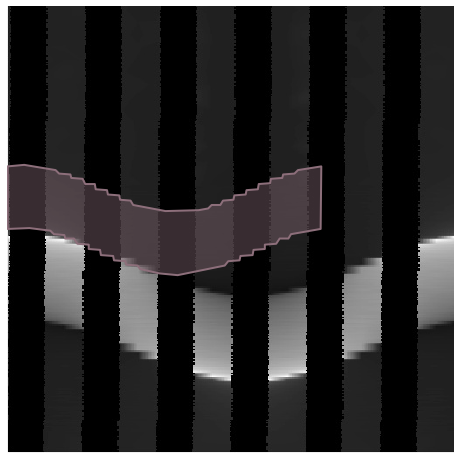

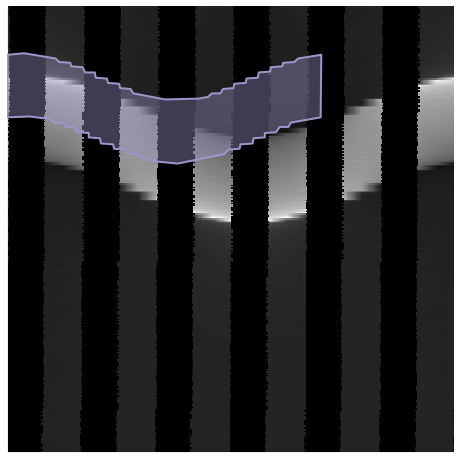

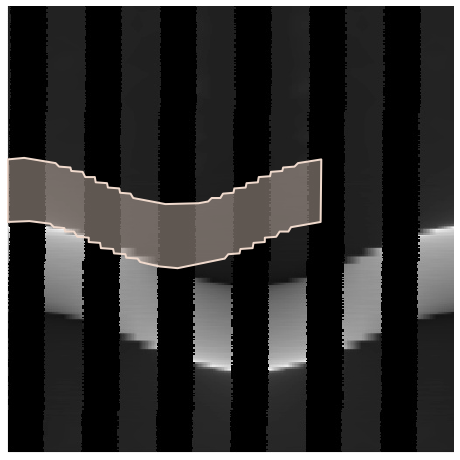

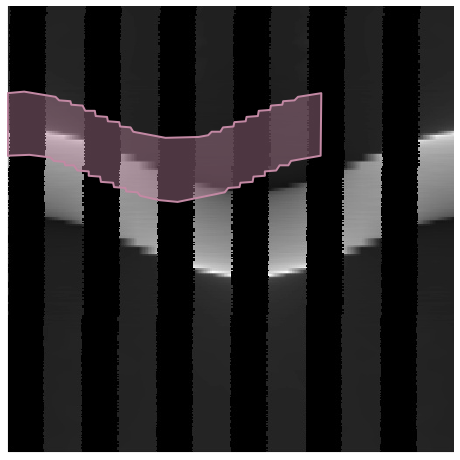

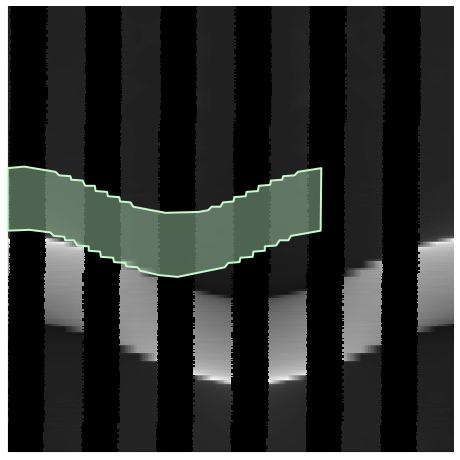

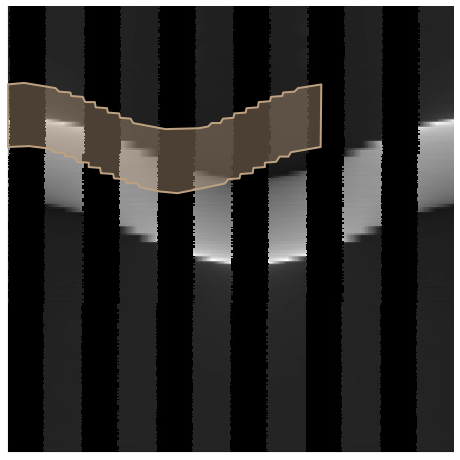

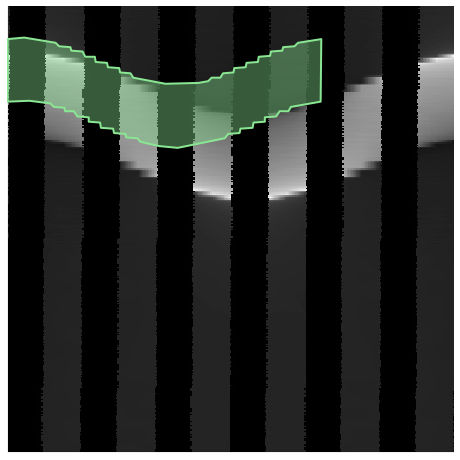

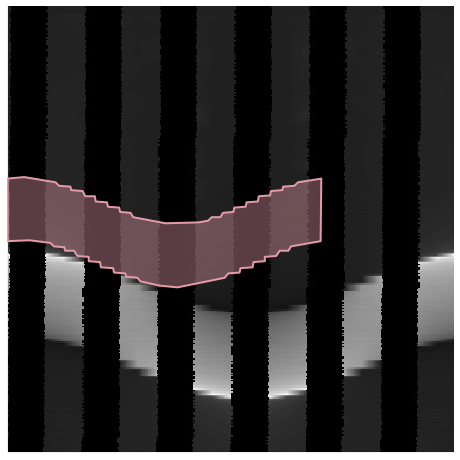

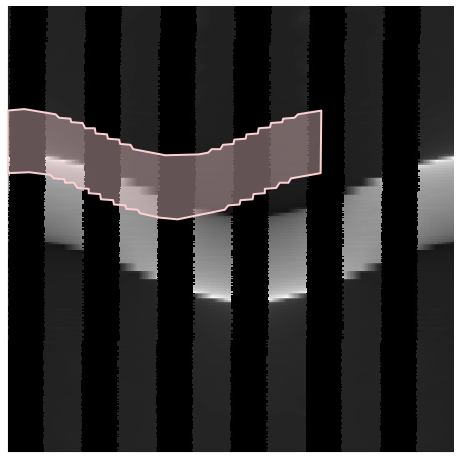

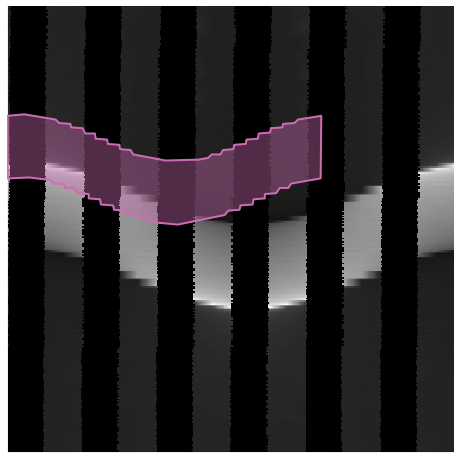

In [27]:
dataset_dir = project_dir / 'VirtualCore/datasets'
anno_dir = dataset_dir / 'train_anno'
img_dir = dataset_dir / 'train'
anno_file = anno_dir /'vircore_train.json'

coco_json = coco_json_utils(anno_file)
coco_img = coco_json.get_coco_img(cat_names = ['bedding_w_dip'], nb_image = 10)
coco_json.plt_image(coco_img, image_dir = img_dir)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
20191103-04:23 | <ipython-input-439-3a3691329bed> - INFO - Open file: /home/phatluu/serviceBot/datasets/coco_example/coco_seg_to_png.json


9it [00:00, 63.52it/s]


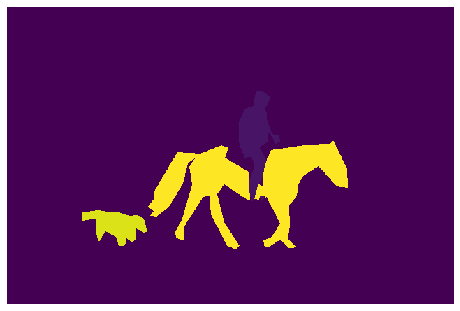

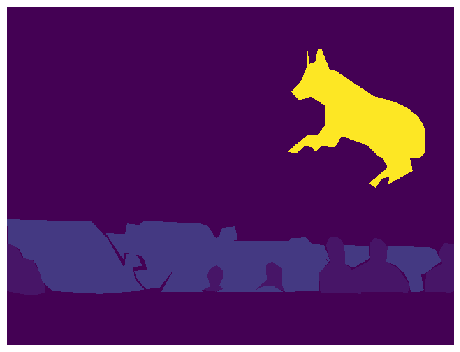

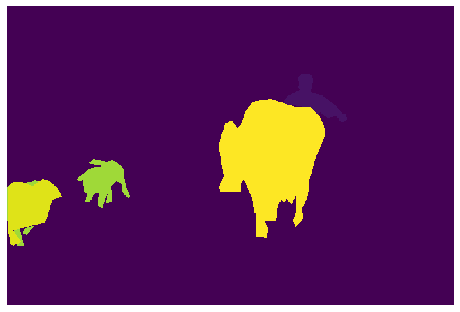

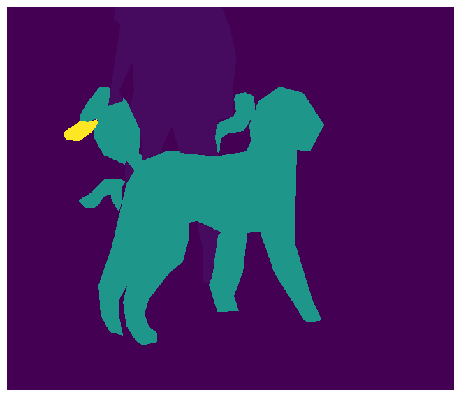

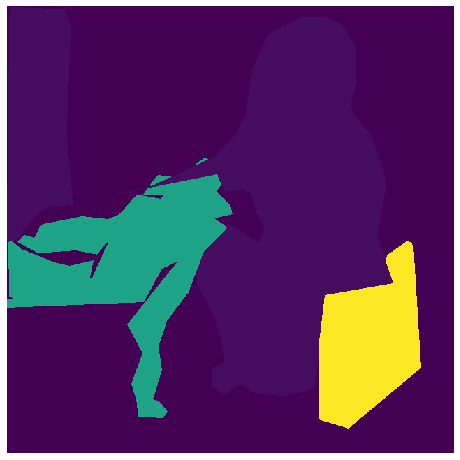

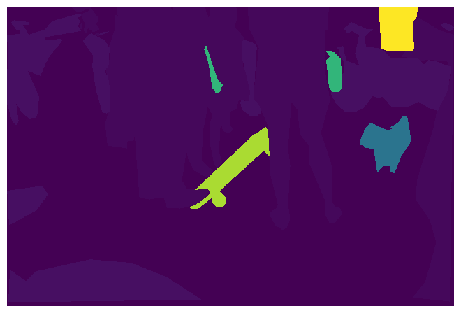

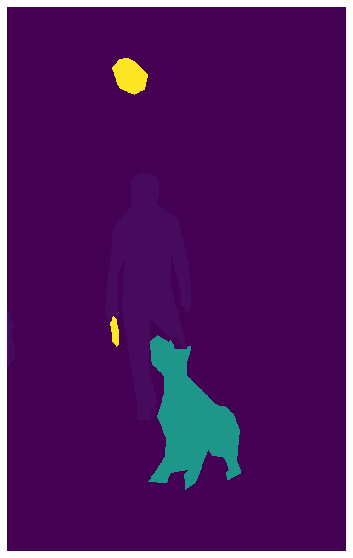

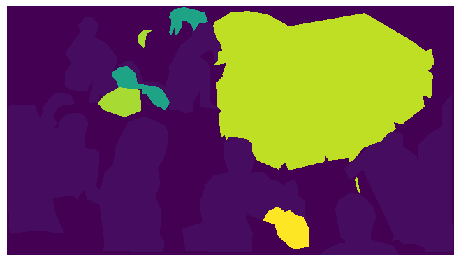

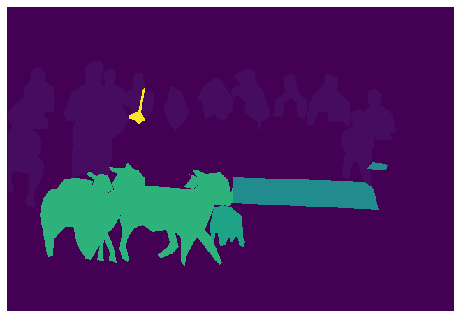

In [442]:
annoDir = project_dir / 'datasets/coco_example'
anno_file = annoDir /'coco_seg_to_png.json'
coco_json = coco_json_utils(anno_file)
coco_img = coco_json.get_coco_img(cat_names = ['person', 'dog'], nb_image = 10)
export_dir = Path(project_dir) / 'datasets/coco_example/segmentation_validate'
coco_json.export_segmentation_png(coco_img, export_dir = export_dir)
# export_dir = Path(project_dir) / 'datasets/coco_example/originalImage'
# for img in coco_img:
#     download_file_url(img['coco_url'], export_dir / img['file_name'])

In [7]:
%autoreload 2
import coco_utils
annoDir = project_dir / 'datasets/coco2017/annotations'
anno_file = annoDir /'instances_val2017.json'
coco_json = coco_utils.coco_json_utils(annoDir/anno_file)

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
20191104-11:53 | coco_utils.py - INFO - Open file: C:\Users\212769892\serviceBot\datasets\coco2017\annotations\instances_val2017.json


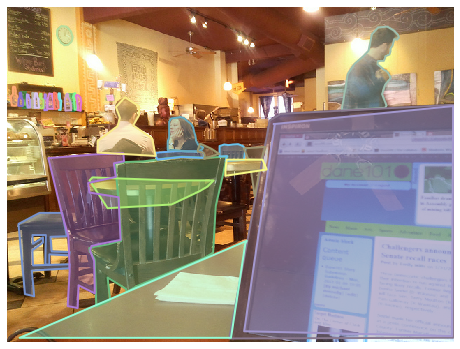

In [8]:
coco_img = coco_json.get_coco_img(cat_names = ['person', 'laptop'], nb_image = 1)
coco_json.plt_image(coco_img)

In [9]:
coco = COCO(anno_file)

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


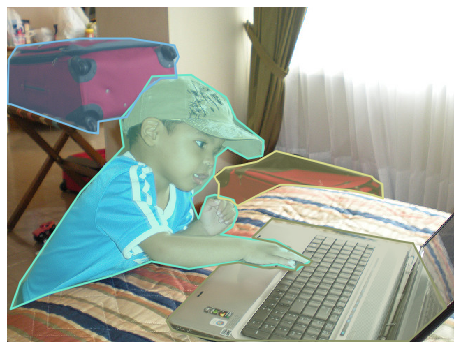

'[{"license": 3, "file_name": "000000358525.jpg", "coco_url": "http://images.cocodataset.org/val2017/000000358525.jpg", "height": 480, "width": 640, "date_captured": "2013-11-18 07:26:34", "flickr_url": "http://farm4.staticflickr.com/3264/2919700209_cc7dd82a5e_z.jpg", "id": 358525}]'

In [20]:
coco_img = coco_json.get_coco_img(cat_names = ['person', 'laptop'], nb_image = 1)
coco_json.plt_image(coco_img)
json.dumps(coco_img)

In [21]:
coco.getAnnIds(imgIds = coco_img[0]['id'])

[467518, 1101133, 1185065, 1185439]

In [24]:
ann_list = coco.loadAnns(ids = coco.getAnnIds(imgIds = coco_img[0]['id']))
cat_list = [ann['category_id'] for ann in ann_list]
print(cat_list)

[1, 73, 33, 33]


In [25]:
for cat in cat_list:
    print(coco_json.get_cat_name(cat))

person
laptop
suitcase
suitcase


In [26]:
import torch
import torch.nn as nn

In [ ]:
nn.Conv2d